In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
logs_df = pd.read_csv('training_logs.txt', sep='\t')
logs_df.head()

,epoch,seed,train,shuffle,accuracy,loss
0,1,10,True,False,28.664,0.030307
1,1,10,False,False,38.670,0.026111
2,2,10,True,False,40.312,0.025191
3,2,10,False,False,45.520,0.023011
4,3,10,True,False,45.804,0.022971


In [3]:
accuracies = {}
losses = {}
train_shuffle_df = logs_df[['epoch', 'accuracy', 'loss']].loc[(logs_df['train']) & (logs_df['shuffle'])]
accuracies['train_shuffle'], losses['train_shuffle'] = train_shuffle_df.groupby('epoch').mean().values.T

test_shuffle_df = logs_df[['epoch', 'accuracy', 'loss']].loc[~(logs_df['train']) & (logs_df['shuffle'])]
accuracies['test_shuffle'], losses['test_shuffle'] = test_shuffle_df.groupby('epoch').mean().values.T

train_noshuffle_df = logs_df[['epoch', 'accuracy', 'loss']].loc[(logs_df['train']) & ~(logs_df['shuffle'])]
accuracies['train_noshuffle'], losses['train_noshuffle'] = train_noshuffle_df.groupby('epoch').mean().values.T

test_noshuffle_df = logs_df[['epoch', 'accuracy', 'loss']].loc[~(logs_df['train']) & ~(logs_df['shuffle'])]
accuracies['test_noshuffle'], losses['test_noshuffle'] = test_noshuffle_df.groupby('epoch').mean().values.T

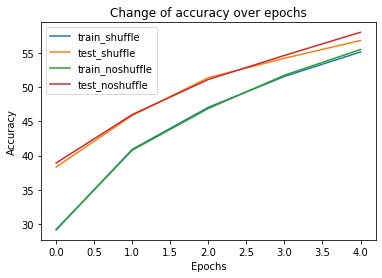

In [4]:
for category, values in accuracies.items():
    plt.plot(range(len(values)), values, label=category)
plt.title('Change of accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

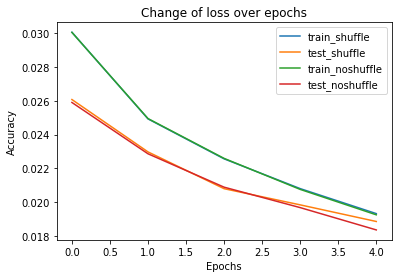

In [5]:
for category, values in losses.items():
    plt.plot(range(len(values)), values, label=category)
plt.title('Change of loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();